In [1]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [2]:
# train_churn_project.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay

In [3]:
#load
df = pd.read_csv(r"C:\Users\Lilian\Downloads\Bank Customer Churn Prediction.csv")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

Shape: (10000, 12)
Columns: ['customer_id', 'credit_score', 'country', 'gender', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary', 'churn']


In [4]:
# 2) Find churn column (helper)
def find_churn_column(df):
    for col in df.columns:
        if "churn" in col.lower() or "exited" in col.lower() or "left" in col.lower():
            return col
    # fallback: binary column with 2 unique values
    for col in df.columns:
        if df[col].nunique() == 2 and col.lower() not in ("gender","country"):
            return col
    return None

churn_col = find_churn_column(df)
if churn_col is None:
    raise ValueError("Couldn't detect churn column. Rename it to 'Churn' or 'Exited' or tell the script which column to use.")
print("Churn column detected:", churn_col)

Churn column detected: churn


In [5]:
print(df[churn_col].value_counts())
print("Missing values:\n", df.isna().sum().sort_values(ascending=False).head(20))

churn
0    7963
1    2037
Name: count, dtype: int64
Missing values:
 customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64


In [6]:
#dropping ID columns. Why? Because they have no predictive power and can confuse the model from learning a real pattern
id_cols = [c for c in df.columns if "id" in c.lower() or "customer" in c.lower() and c!=churn_col]
df = df.drop(columns = id_cols, errors='ignore')

In [7]:
# Normalize churn to 0/1
def normalize_churn(series):
    if series.dtype == object:
        return series.replace({"Yes":1,"No":0,"Y":1,"N":0,"True":1,"False":0,"TRUE":1,"FALSE":0}).astype(int)
    if set(series.dropna().unique()) <= {0,1}:
        return series.astype(int)
    uniques = sorted(series.dropna().unique())
    if len(uniques)==2:
        mapping = {uniques[0]:0, uniques[1]:1}
        return series.map(mapping).astype(int)
    raise ValueError("Unhandled churn encoding.")
df[churn_col] = normalize_churn(df[churn_col])

In [8]:
#Feature splits -- separates the inputs from the output, and identifies which of those features are numerical and categorical
X = df.drop(columns = [churn_col])
y = df[churn_col]
num_features = X.select_dtypes(include = [np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude = [np.number]).columns.tolist()
print("Numeric:", num_features)
print("Categorical:", cat_features)

Numeric: ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary']
Categorical: ['country', 'gender']


In [9]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)

In [10]:
#preprocessing
#Defines & prepares diff data transformations that must be applied to the numerical & categorical features separately before the ML model sees the data
preprocessor = ColumnTransformer(transformers = [
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features)
],remainder='drop')

In [11]:
#logistic regression baseline
log_pipe = Pipeline([("pre", preprocessor),("clf", LogisticRegression(max_iter=1000))])
log_pipe.fit(X_train, y_train)
y_pred_log = log_pipe.predict(X_test)
y_proba_log = log_pipe.predict_proba(X_test) [:,1]
print("Logistic Regression - accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression - ROC AUC:", roc_auc_score(y_test, y_proba_log))
print(classification_report(y_test, y_pred_log))

Logistic Regression - accuracy: 0.808
Logistic Regression - ROC AUC: 0.7747578086561138
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.59      0.19      0.28       407

    accuracy                           0.81      2000
   macro avg       0.71      0.58      0.59      2000
weighted avg       0.78      0.81      0.77      2000



In [12]:
rf_pipe = Pipeline([("pre", preprocessor),("clf", RandomForestClassifier(random_state = 42, n_jobs = -1))])
param_grid = {
    "clf__n_estimators":[100,200],
    "clf__max_depth":[5,10,None]
}
gscv = GridSearchCV(rf_pipe, param_grid, cv=3, scoring="roc_auc", n_jobs = -1)
gscv.fit(X_train, y_train)
best_rf = gscv.best_estimator_
print("Best RF params:", gscv.best_params_)

y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test) [:,1]
print("Random Forest - accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest - ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print(classification_report(y_test, y_pred_rf))

Best RF params: {'clf__max_depth': 10, 'clf__n_estimators': 200}
Random Forest - accuracy: 0.8675
Random Forest - ROC AUC: 0.8612032679829289
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1593
           1       0.83      0.44      0.57       407

    accuracy                           0.87      2000
   macro avg       0.85      0.71      0.75      2000
weighted avg       0.86      0.87      0.85      2000



In [13]:
cm = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[1557   36]
 [ 229  178]]


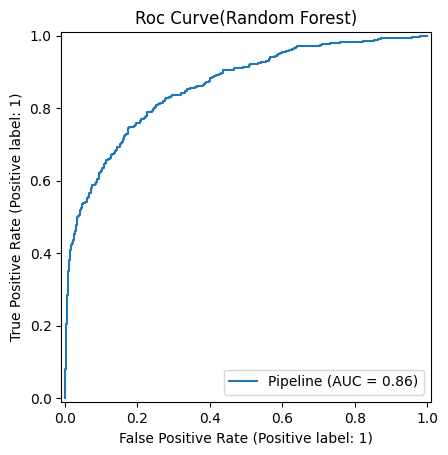

In [14]:
#ROC curve
RocCurveDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("Roc Curve(Random Forest)")
plt.savefig('Roc_Curve_Random_Forest.png', dpi=300, bbox_inches = 'tight')
plt.show()

In [16]:
pre = best_rf.named_steps["pre"]
num_names = num_features
cat_names = []
if len(cat_features)>0:
    ohe = pre.named_transformers_["cat"]
    cat_names = list(ohe.get_feature_names_out(cat_features))
feature_names = num_names + cat_names
importances = best_rf.named_steps["clf"].feature_importances_
feat_imp = pd.DataFrame({"feature":feature_names,"importance":importances}).sort_values("importance",ascending = False).head(20)
print("Top features:\n", feat_imp)

Top features:
              feature  importance
1                age    0.309169
4    products_number    0.209672
3            balance    0.107772
0       credit_score    0.087342
7   estimated_salary    0.084418
6      active_member    0.060142
2             tenure    0.045710
9    country_Germany    0.039146
8     country_France    0.012573
5        credit_card    0.012038
12       gender_Male    0.011585
11     gender_Female    0.010709
10     country_Spain    0.009724


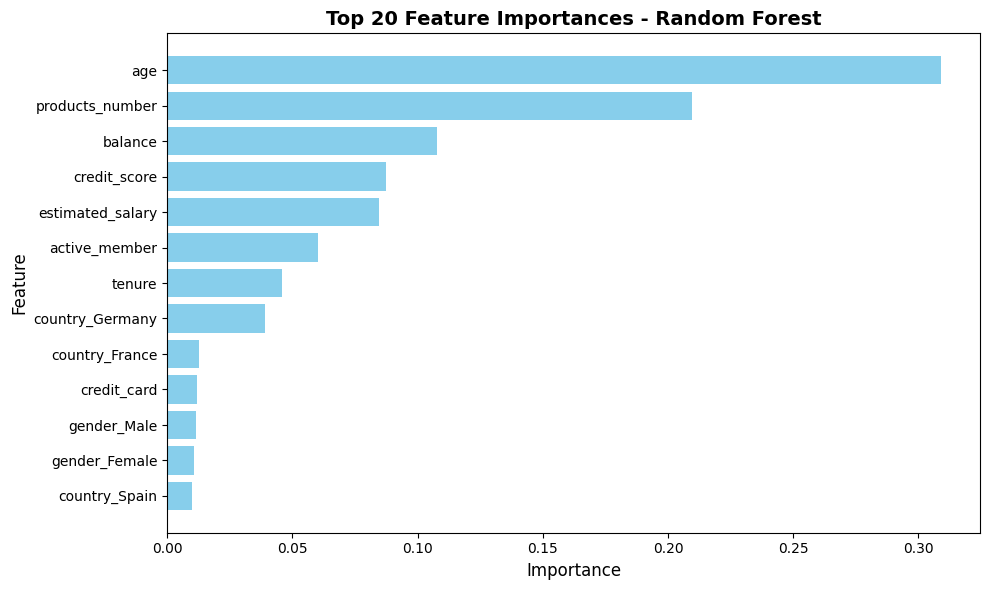

In [17]:
# Visualize top feature importances
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'], feat_imp['importance'], color='skyblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Feature Importances - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.savefig('Feature_Importances_Random_Forest.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
#high-risk watchlist(top 100)
proba_full = best_rf.predict_proba(X)[:,1]
watchlist = X.copy()
watchlist["churn_probability"] = proba_full
#if original had an id column that was dropped, recreate index ID
if "customer_id" in df.columns:
    watchlist["customer_id"] = df["customer_id"]
else:
    watchlist = watchlist.reset_index().rename(columns={"index":"customer_index"})
watchlist_sorted = watchlist.sort_values("churn_probability",ascending=False).head(100)
watchlist_sorted.to_csv("high_risk_watchlist_top100.csv",index=False)
print("Saved high_risk_watchlist_top100.csv")

Saved high_risk_watchlist_top100.csv


In [19]:
#save model pipeline
joblib.dump(best_rf, "best_churn_model.pkl")
print("Saved best_churn_model.pkl")

Saved best_churn_model.pkl


In [20]:
#saving a small report
with open("model_summary.txt","w") as f:
    f.write(f"Logistic ROC AUC:{roc_auc_score(y_test,y_proba_log):.4f}\n")
    f.write(f"Random Forest ROC AUC:{roc_auc_score(y_test,y_proba_rf):.4f}\n")
    f.write("Best RF Params: " + str(gscv.best_params_) + "\n")
print("Done.")

Done.
